In [2]:
! export CUDA_LAUNCH_BLOCKING=1

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import logging
import os
import re
import h5py
import numpy as np
import pandas as pd
import random
from torch import nn
import torchvision
import torch.nn.functional as F
from datetime import datetime

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

logger = logging.getLogger(__name__)
if logger.handlers:
    logger.handlers = []
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())        

In [5]:
device = torch.device('cuda')
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='TITAN Xp', major=6, minor=1, total_memory=12196MB, multi_processor_count=30)

In [6]:
def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [7]:
def median_smoothing(signal, width=3):
    s = signal[:]
    half_width = int(width/2)
    for i in range(half_width, len(signal)):
        s[i-half_width] = torch.median(signal[i-half_width:i+half_width])
    return s

# Extract data to predict from fast5s

In [8]:
molbit_all_data_file = "/path/to/data/v4_test/20190830_all.hdf5"
molbit_labeled_data_file = "/path/to/data/v4_test/20190830_only_labeled.hdf5"

## Define functions for preprocessing data

In [9]:
def med_mad(data, factor=1.4826):
    """Modified from Mako.
    Compute the Median Absolute Deviation, i.e., the median
    of the absolute deviations from the median, and the median.

    :param data: A :class:`ndarray` object
    :param axis: For multidimensional arrays, which axis to calculate over 

    :returns: a tuple containing the median and MAD of the data

    .. note :: the default `factor` scales the MAD for asymptotically normal
        consistency as in R.

    """
    dmed = torch.median(data)
    dmad = factor * torch.median(torch.abs(data - dmed))
    return dmed, dmad

def _scale_data( data):
    '''Modified from Mako.'''
    med, mad = med_mad(data)
    data = (data - med) / mad
    return data

In [10]:
def get_signal_regions_less_than(signal, signal_threshold=180.):
    signal_mask = np.where(signal <= signal_threshold, 1, 0)
    signal_chg_pts = np.where(np.abs(np.diff(signal_mask)) == 1)[0]

    if signal[0] <= signal_threshold:
        signal_chg_pts = np.insert(signal_chg_pts, 0, 0)
    if signal[-1] <= signal_threshold:
        signal_chg_pts = np.append(signal_chg_pts, len(signal_mask))

    signal_regions = list(zip(signal_chg_pts[::2], signal_chg_pts[1::2]))

    return signal_regions

def get_signal_regions_greater_than(signal, signal_threshold=180.):
    signal_mask = np.where(signal >= signal_threshold, 1, 0)
    signal_chg_pts = np.where(np.abs(np.diff(signal_mask)) == 1)[0]

    if signal[0] >= signal_threshold:
        signal_chg_pts = np.insert(signal_chg_pts, 0, 0)
    if signal[-1] >= signal_threshold:
        signal_chg_pts = np.append(signal_chg_pts, len(signal_mask))

    signal_regions = list(zip(signal_chg_pts[::2], signal_chg_pts[1::2]))

    return signal_regions

def median_smoothing(signal, width=3):
    s = signal[:]
    half_width = int(width/2)
    for i in range(half_width, len(signal)):
        s[i-half_width] = torch.median(signal[i-half_width:i+half_width])
    return s


In [11]:
def trim_start_heuristic(signal, thresh=2, offset=20):
    try:
        above = np.where(signal[offset:] > thresh)[0][0] + offset
    except IndexError:
        above = 0
    return signal[above:]

## Get run info

In [12]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gdrive_key_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [13]:
run_name = "08_30_2019_run_01"

## Import fast5s

### Get a list of fast5 files to import

In [14]:
fast5_root_dir = list(run_spreadsheet[run_spreadsheet["run_name"] == run_name]["raw_fast5_dir_multi"])[0]
fast5_dirs = [os.path.join(fast5_root_dir, x) for x in os.listdir(fast5_root_dir) if "fast5" in x]
fast5_files = []
for f5_dir in fast5_dirs:
    fast5_files.extend([os.path.join(f5_dir, x) for x in os.listdir(f5_dir) if x.endswith("fast5")])

In [15]:
label_file = list(run_spreadsheet[run_spreadsheet["run_name"] == run_name]["filtered_sw_labels"])[0]

## Import, sorting by labeled vs. not

In [16]:
all_data = []
all_fast5_read_ids = []

labeled_data = []
labeled_read_ids = []
labels = []
labels_in_order = []

max_len = 3000

sw = pd.read_csv(label_file, sep="\t", index_col=0)
labels = np.array(sw["molbit"])
read_ids = list(sw.index)

for f5_file in fast5_files:
    with h5py.File(f5_file, "r") as f5:
        for group in f5.get("/").values():
            read_id = re.findall(r'read_(.*)" \(', str(group))[0]
            all_fast5_read_ids.append(read_id)
            
            raw = group.get("Raw/Signal")[:15000]                    
                    
            x = torch.FloatTensor(list(raw))
            x = _scale_data(x)
            x = trim_start_heuristic(x)
            x = x[:max_len]
            y = torch.zeros(max_len)
            y[:len(x)] = x
            
            all_data.append(y)
            
            if read_id in sw.index:  
                i = read_ids.index(read_id)
                
                labeled_data.append(y)
                labeled_read_ids.append(read_id)
                labels_in_order.append(labels[i])

KeyboardInterrupt: 

In [ ]:
all_fast5_data = torch.stack(all_data)
all_fast5_data = all_fast5_data.unsqueeze(1)

In [ ]:
labeled_data = torch.stack(labeled_data)
labeled_data = labeled_data.unsqueeze(1)

In [ ]:
with h5py.File(molbit_all_data_file, "w", swmr=True) as f:
    f.create_dataset("read_ids", shape=(len(all_fast5_read_ids), ), data=np.array(all_fast5_read_ids, dtype="S"))
    f.create_dataset("data", shape=all_fast5_data.shape, dtype=np.float, data=all_fast5_data)    

In [ ]:
with h5py.File(molbit_labeled_data_file, "w", swmr=True) as f:
    f.create_dataset("data", shape=labeled_data.shape, dtype=np.float, data=labeled_data)
    f.create_dataset("labels", shape=(len(labels_in_order), ), dtype=int, data=labels_in_order)
    f.create_dataset("read_ids", shape=(len(labeled_read_ids), ), data=np.array(labeled_read_ids, dtype="S"))

## Load saved data

In [17]:
with h5py.File(molbit_all_data_file, "r") as f:
    all_fast5_read_ids = f.get("read_ids")[()]
    all_fast5_data = f.get("data")[()]

In [18]:
with h5py.File(molbit_labeled_data_file, "r") as f:
    labeled_data = f.get("data")[()]
    labels_in_order = f.get("labels")[()]
    labeled_read_ids = f.get("read_ids")[()]

# Create a MolbitDataset from the extracted data

In [17]:
class MolbitDataset(Dataset):
    def __init__(self, data_file, unknown_labels=False):
        with h5py.File(data_file, "r") as f:
            self.data = torch.FloatTensor(f.get("data")[()])
            self.n_records = self.data.shape[0]
            self.max_len = self.data.shape[2]
            try:
                self.labels = torch.IntTensor(f.get("labels")[()])
                self.n_labels = len(np.unique(self.labels))
            except:
                self.labels = torch.IntTensor([-1 for _ in range(self.n_records)])
                self.n_labels = 0

        # Shuffle data
        self.shuffle_index = np.random.choice(range(self.n_records), replace=False, size=self.n_records)
        self.data = self.data[self.shuffle_index]       
        self.labels = self.labels[self.shuffle_index]        
        
    def _get_onehot(self, label):
        if self.labels is None:
            return None
        ix = self.labels.index(label)
        onehot = torch.zeros(self.n_labels)
        onehot[ix] = 1
        return onehot
    
    def __len__(self):
        return self.n_records
        
    def __getitem__(self, idx):
        return self.data[idx, :, :], self.labels[idx]

In [18]:
md_all = MolbitDataset(molbit_all_data_file, unknown_labels=True)

In [19]:
md_labeled = MolbitDataset(molbit_labeled_data_file, unknown_labels=True)

# Load saved model

In [20]:
class CNN(nn.Module):

    def __init__(self):

        super(CNN, self).__init__()

        O_1 = 64
        O_2 = 128
        O_3 = 256
        O_4 = 512
        O_5 = 1024

        K_1 = 15
        K_2 = 8
        K_3 = 6
        K_4 = 4
        K_5 = 2

        KP_1 = 6
        KP_2 = 3
        KP_3 = 2
        KP_4 = 2
        KP_5 = 1

        FN_1 = 1000
        FN_2 = 500

        self.conv1 = nn.Sequential(nn.Conv1d(1, O_1, K_1, stride=1), nn.ReLU(),
                                   nn.AvgPool1d(KP_1))
        self.conv1_bn = nn.BatchNorm1d(O_1)

        self.conv2 = nn.Sequential(nn.Conv1d(O_1, O_2, K_2), nn.ReLU(),
                                   nn.AvgPool1d(KP_2))
        self.conv2_bn = nn.BatchNorm1d(O_2)

        self.conv3 = nn.Sequential(nn.Conv1d(O_2, O_3, K_3), nn.ReLU(),
                                   nn.AvgPool1d(KP_3))
        self.conv3_bn = nn.BatchNorm1d(O_3)

        self.conv4 = nn.Sequential(nn.Conv1d(O_3, O_4, K_4), nn.ReLU(),
                                   nn.AvgPool1d(KP_4))
        self.conv4_bn = nn.BatchNorm1d(O_4)

        self.conv5 = nn.Sequential(nn.Conv1d(O_4, O_5, K_5), nn.ReLU(),
                                   nn.AvgPool1d(KP_5))
        self.conv5_bn = nn.BatchNorm1d(O_5)

        self.gru1 = nn.GRU(input_size=92160, hidden_size=10, num_layers=1)

        self.fc1 = nn.Linear(37888, FN_1, nn.Dropout(0.5)) # 37888 20480 28672 9216
        self.fc1_bn = nn.BatchNorm1d(FN_1)

        self.fc2 = nn.Linear(FN_1, FN_2, nn.Dropout(0.5))
        self.fc2_bn = nn.BatchNorm1d(FN_2)

        self.fc3 = nn.Linear(FN_2, 96)

    def forward(self, x):
        x = x.float()
#         print("a", np.shape(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_bn(x))
#         print("b", np.shape(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_bn(x))
#         print("c", np.shape(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_bn(x))
#         print("d", np.shape(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.relu(self.conv4_bn(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.relu(self.conv5_bn(x))
#         print("e", np.shape(x))
        x = x.view(len(x), -1)
#         print("f", np.shape(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc1_bn(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2_bn(x))
#         print("g", np.shape(x))

        x = self.fc3(x)
#         print("h", np.shape(x))
        return x


In [21]:
model_file = "saved_models/molbit_classification_v4_0_1.20190827.pt"

In [22]:
model = CNN()
model.load_state_dict(torch.load(model_file))
model.cuda()
model.eval()


CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(15,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  )
  (conv1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  )
  (conv2_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(6,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv3_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv4_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, af

# Predict on all data

In [23]:
test_loader_params = {"batch_size": 500,
          "shuffle": False,
          "num_workers": 30}
test_generator = DataLoader(md_all, **test_loader_params)

In [25]:
y_pred_all = []
y_pred_score = []
for i, (local_batch, local_labels) in enumerate(test_generator):
    # Transfer to GPU
    local_batch = local_batch.to(device)
    y_pred = model(local_batch).to(dtype=torch.float64)
    
    softmax_score = torch.nn.functional.softmax(y_pred, dim=1)
    pred_score, prediction = torch.max(softmax_score, dim=1)

    y_pred_all.extend([int(x) if s > 0.9 else -1 for s, x in zip(pred_score.cpu(), prediction.cpu())])
    y_pred_score.extend([float(x) for x in pred_score.cpu()])

In [26]:
len(np.where(np.array(y_pred_all) == -1)[0])

13399

In [1]:
(376149 - 13399) / 376149


0.9643784776777288

In [27]:
len(y_pred_all)

376149

## Save to tsv file

In [28]:
cnn_df = pd.DataFrame()
cnn_df["read_id"] = all_fast5_read_ids.astype(str)
cnn_df["cnn_label"] = y_pred_all
cnn_df["cnn_score"] = y_pred_score

In [29]:
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [30]:
basecall_dir = run_data.get("basecall_dir")

In [31]:
try:
    os.makedirs(os.path.join(basecall_dir, "cnn"))
except:
    pass

In [32]:
cnn_label_file = os.path.join(basecall_dir, "cnn", "model_v4_0_1_all_reads" + label_file.split("_")[-1])

In [33]:
cnn_df.to_csv(cnn_label_file, sep="\t", index=False)

In [34]:
cnn_label_file

'/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/cnn/model_v4_0_1_all_readsee80935b39ac8eac3e848aa0e1f003f3f7be1c96.tsv'

## Read from tsv file

In [19]:
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [20]:
basecall_dir = run_data.get("basecall_dir")

In [21]:
cnn_label_file = os.path.join(basecall_dir, "cnn", "model_v4_0_1_all_reads" + label_file.split("_")[-1])

In [22]:
cnn_df = pd.read_csv(cnn_label_file, sep="\t")

In [23]:
cnn_df

,read_id,cnn_label,cnn_score
0,000ee75e-b702-4b3d-a03a-0a2ecc658beb,42,1.000000
1,001cef08-ae33-4106-be0b-edd7ff3135e8,8,1.000000
2,00385598-b4bb-444c-a1c8-7e08ea11e0b6,78,0.978846
3,003ef37f-bd26-4368-bffc-b1d20d16e7be,40,0.999998
4,004bb378-cf99-4979-8d13-b4d35f593e38,9,1.000000
5,00763310-dd23-4564-8635-15ace4c33d82,44,1.000000
6,00771795-1e0f-41b3-8f50-5601a9e009ae,73,1.000000
7,0090e3a5-0410-4477-ba19-47d0af12a6e3,57,1.000000
8,0093ba88-d519-49c5-8539-bd5da48b6b54,9,1.000000
9,00a1aa43-d085-4bb9-88b3-ffc40d563cc5,9,1.000000


In [24]:
y_pred_all = cnn_df["cnn_label"]
y_pred_score = cnn_df["cnn_score"]
all_fast5_read_ids = cnn_df["read_id"]

## Sum up read counts

In [25]:
l_all, c_all = np.unique(y_pred_all, return_counts=True)
print(list(zip(l_all, c_all)))

[(-1, 13399), (0, 199), (1, 300), (2, 221), (3, 679), (4, 183), (5, 234), (6, 143), (7, 176), (8, 5817), (9, 46099), (10, 4313), (11, 5437), (12, 13970), (13, 986), (14, 3463), (15, 14406), (16, 237), (17, 111), (18, 133), (19, 508), (20, 204), (21, 735), (22, 100), (23, 99), (24, 1100), (25, 3080), (26, 6671), (27, 4301), (28, 1849), (29, 4470), (30, 13098), (31, 10749), (32, 771), (33, 149), (34, 150), (35, 77), (36, 337), (37, 166), (38, 154), (39, 163), (40, 6574), (41, 7273), (42, 5204), (43, 18630), (44, 7734), (45, 6725), (46, 2519), (47, 2720), (48, 168), (49, 336), (50, 715), (51, 303), (52, 121), (53, 433), (54, 249), (55, 75), (56, 4114), (57, 3162), (58, 7832), (59, 1799), (60, 14850), (61, 2882), (62, 4679), (63, 7896), (64, 23), (65, 262), (66, 193), (67, 97), (68, 128), (69, 209), (70, 81), (71, 152), (72, 7538), (73, 4928), (74, 14916), (75, 6296), (76, 970), (77, 10722), (78, 1693), (79, 1833), (80, 144), (81, 215), (82, 234), (83, 814), (84, 118), (85, 397), (86, 512)

In [26]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(30, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='k', edgecolor='k',
                         label='never been run on this flowcell'),
                       Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='prev run on flowcell'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='current run on flowcell')]
    leg = ax.legend(handles=legend_elements)
    t1, t2, t3 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
    t3._fontproperties = t1._fontproperties.copy()
    t2.set_weight('bold')
    t3.set_weight('bold')
    t3.set_color("tab:red")
    return ax

In [27]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [28]:
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

6
['0', '1', '2', '3', '4', '5', '6', '7', '16', '17', '18', '19', '20', '21', '22', '23', '32', '33', '34', '35', '36', '37', '38', '39', '48', '49', '50', '51', '52', '53', '54', '55', '64', '65', '66', '67', '68', '69', '70', '71', '80', '81', '82', '83', '84', '85', '86', '87']
['8', '9', '10', '11', '12', '13', '14', '15', '24', '25', '26', '27', '28', '29', '30', '31', '40', '41', '42', '43', '44', '45', '46', '47', '56', '57', '58', '59', '60', '61', '62', '63', '72', '73', '74', '75', '76', '77', '78', '79', '88', '89', '90', '91', '92', '93', '94', '95', '0', '1', '2', '3', '4', '5', '6', '7', '16', '17', '18', '19', '20', '21', '22', '23', '32', '33', '34', '35', '36', '37', '38', '39', '48', '49', '50', '51', '52', '53', '54', '55', '64', '65', '66', '67', '68', '69', '70', '71', '80', '81', '82', '83', '84', '85', '86', '87']


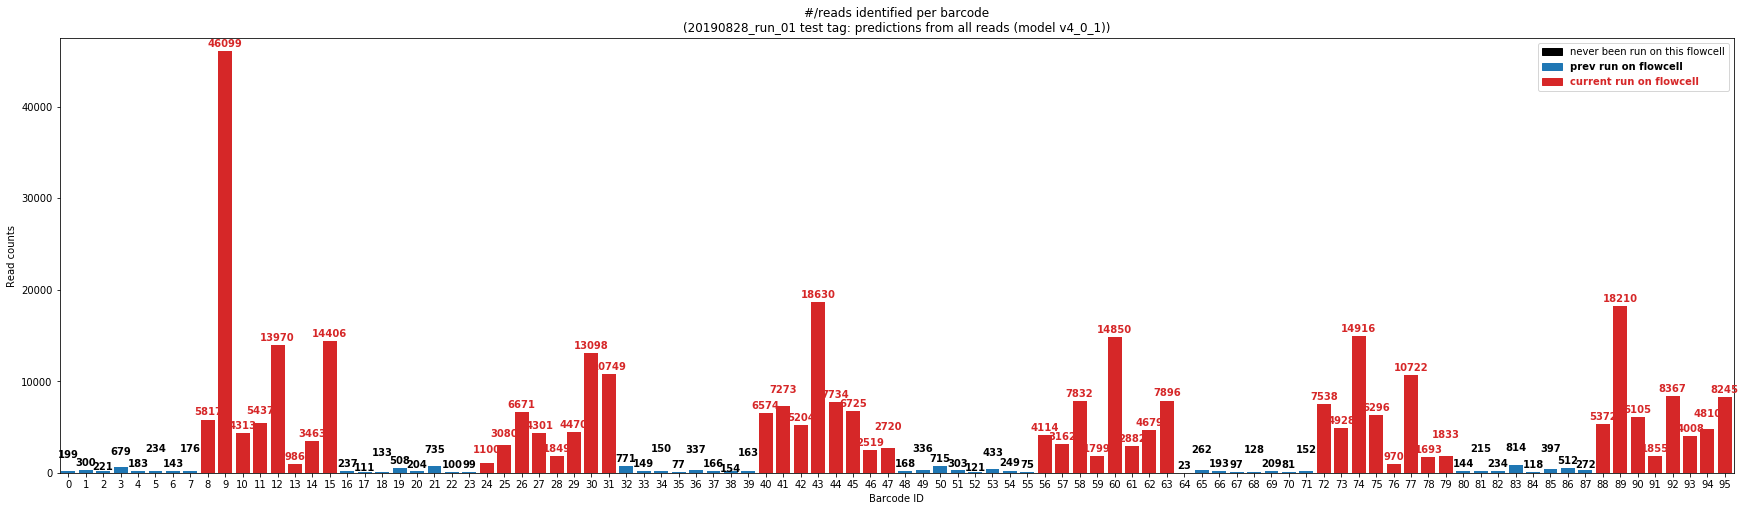

In [43]:
molbits = [str(x) for x in l_all]
counts = list(c_all)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts,
                 on_flowcell, in_run,
                 possible_labels=poss_molbits,
                 vmax=47500,
                 title_note="20190828_run_01 test tag: predictions from all reads (model v4_0_1)")
plt.savefig(f"/ssd1/home/kdorosch/code/punchcard-tagger/v4/plots/by_run/{run_name}_model_v4_0_1_preds.svg")

# Predict on labeled data

In [40]:
test_loader_params = {"batch_size": 500,
          "shuffle": False,
          "num_workers": 30}
test_generator = DataLoader(md_labeled, **test_loader_params)

In [41]:
torch.cuda.empty_cache()

In [42]:
y_pred_labeled = []
y_true_labeled = []
y_pred_score = []
for i, (local_batch, local_labels) in enumerate(test_generator):
    # Transfer to GPU
    local_batch = local_batch.to(device)
    local_labels = local_labels.to(device)
    y_pred = model(local_batch).to(dtype=torch.float64)
    local_labels = local_labels.to(dtype=torch.long)
    
    softmax_score = torch.nn.functional.softmax(y_pred, dim=1)
    pred_score, prediction = torch.max(softmax_score, dim=1)

    y_pred_labeled.extend([int(x) for x in prediction.cpu()])
    y_true_labeled.extend([int(x) for x in local_labels.cpu()])
    y_pred_score.extend([float(x) for x in pred_score.cpu()])

In [43]:
cnn_df_labeled = pd.DataFrame()
cnn_df_labeled["read_id"] = labeled_read_ids.astype(str)
cnn_df_labeled["cnn_label"] = y_pred_labeled
cnn_df_labeled["cnn_score"] = y_pred_score
cnn_df_labeled["sw_label"] = y_true_labeled

In [44]:
cnn_label_file = os.path.join(basecall_dir, "cnn", "model_v4_0_1_labeled_reads" + label_file.split("_")[-1])

In [45]:
cnn_df_labeled.to_csv(cnn_label_file, sep="\t", index=False)

In [46]:
cnn_label_file

'/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/cnn/model_v4_0_1_labeled_readsee80935b39ac8eac3e848aa0e1f003f3f7be1c96.tsv'

## Load predictions

In [30]:
cnn_label_file = os.path.join(basecall_dir, "cnn", "model_v4_0_1_labeled_reads" + label_file.split("_")[-1])

In [31]:
cnn_df_labeled = pd.read_csv(cnn_label_file, sep="\t")

In [32]:
labeled_read_ids = cnn_df_labeled["read_id"]
y_pred_labeled = cnn_df_labeled["cnn_label"]
y_pred_score = cnn_df_labeled["cnn_score"]
y_true_labeled = cnn_df_labeled["sw_label"]

# Evaluate error

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
np.sum([x == y for x, y in zip(y_true_labeled, y_pred_labeled)]), len(y_true_labeled)

(238536, 249013)

In [35]:
1. * np.sum([x == y for x, y in zip(y_true_labeled, y_pred_labeled)]) / len(y_true_labeled)

0.9579258914193235

In [36]:
l, c = np.unique(y_true_labeled, return_counts=True)

In [37]:
norm = []
for molbit in range(96):
    if molbit in l:
        i = list(l).index(molbit)
        norm.append(c[i])
    else:
        norm.append(1)
norm = np.array(norm)

In [38]:
cm = confusion_matrix(y_true_labeled, y_pred_labeled)

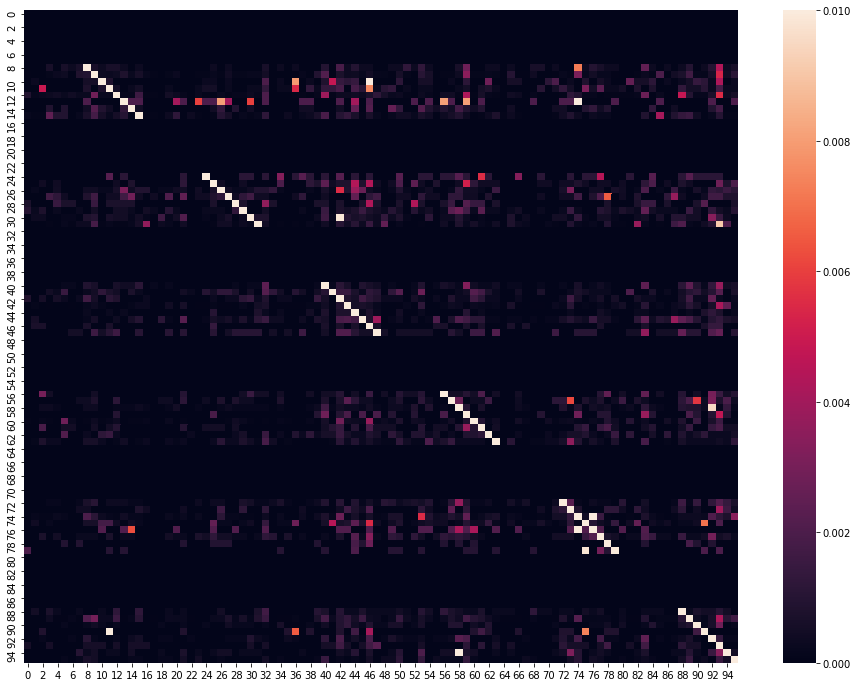

In [39]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm / norm[:, np.newaxis], vmin=0, vmax=0.01)
plt.savefig(f"/ssd1/home/kdorosch/code/punchcard-tagger/v4/plots/by_run/{run_name}_model_v4_0_1_cm.svg")